In [97]:
import sys
sys.path.append('./../../')
sys.path.append('./..')
sys.path.append('./../../designer/script/')


from film import FreeFormFilm, BaseFilm
from design import BaseDesign
from spectrum import BaseSpectrum
from optimizer.adam import AdamFreeFormOptimizer

from analyze_utils.make_design import make_edgefilter_design, make_reflection_design, make_three_line_filter_design
from utils.loss import calculate_RMS_f_spec
from analyze_utils.result_io import save, load
from analyze_utils.structure import plot_layer_thickness

import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle

In [104]:
# design = make_edgefilter_design()
# design = make_reflection_design(wls=np.linspace(695, 939, 500))
reps = 10
gts = np.linspace(1000, 10000, 10)
n_size = 2000
n_min = 1.5
n_max = 3

# adam optimizer parameters
alpha = 0.1
batch_size = 200

def exp(n_size, total_gt, design):
    np.random.seed()
    init_n = np.random.random(n_size) * 3 + 1
    init_film = FreeFormFilm(init_n, total_gt, substrate='SiO2')

    adam_optimizer = AdamFreeFormOptimizer(
        init_film, 
        design.target_specs, 
        max_steps=1000, 
        alpha=alpha, 
        record=True, 
        show=False, 
        n_min=n_min, 
        n_max=n_max,
        wl_batch_size=batch_size
    )

    films, losses = adam_optimizer.optimize()
    return films, losses, copy.deepcopy(init_film)

def scan_gts(wl_min, wl_max):
    design = make_reflection_design(wls=np.linspace(wl_min, wl_max, 500))


    films_rep, losses_rep, best_film_rep = [], [], []
    for rep in range(reps):
        films_rep.append([])
        losses_rep.append([])
        best_film_rep.append([])
        for gt in gts:
            films, losses, best_film = exp(n_size, gt, design)
            films_rep[-1].append(films)
            losses_rep[-1].append(losses)
            best_film_rep[-1].append(best_film)
    return films_rep, losses_rep, best_film_rep, design


dependence on hyperparams

In [45]:
def arr_to_fill(ax, x, arr, rep_axis=0, label=''):
    arr = np.array(arr)
    mean = arr.mean(axis=rep_axis)
    std = arr.std(axis=rep_axis)

    ax.plot(x, mean, label=label,)
    ax.fill_between(x, mean - std, mean + std, label='label'+' err bar (1 sigma)', alpha=0.4)

def show_scan_gts(gts, best_film_rep, design, fig=None, ax=None):
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, 1)
    best_loss_rep = [[
            np.log10(calculate_RMS_f_spec(
                best_film, 
                design.target_specs, 
            )) for best_film in best_film_ls] 
        for best_film_ls in best_film_rep]

    arr_to_fill(ax, gts, best_loss_rep, label=f'target wl range: {design.target_specs[0].WLS[0]: .0f} to {design.target_specs[0].WLS[-1]: .0f} nm')
    ax.legend()
    ax.set_xlabel('initial gt')
    ax.set_ylabel('log10 loss')
    return fig, ax 

In [105]:

fig, ax = plt.subplots(1, 1)

for wl_min, wl_max in zip([600, 550, 400], [800, 1200, 1500]):
    films_rep, losses_rep, best_film_rep, design = scan_gts(wl_min, wl_max)
    show_scan_gts(gts, best_film_rep, design, fig, ax)
    save(f'./raw_result/reflector_minwl_{wl_min}_maxwl_{wl_max}_batch_size_{batch_size}_alpha_{alpha}_n_min{n_min}_n_max{n_max}', losses_rep, best_film_rep, design)
    

0.011828623277335679
film has no spec. use 1000 nm


c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(<AxesSubplot: title={'center': 'refractive index distribution at  1000 nm'}, xlabel='position / nm'>,
 <Figure size 600x100 with 1 Axes>)

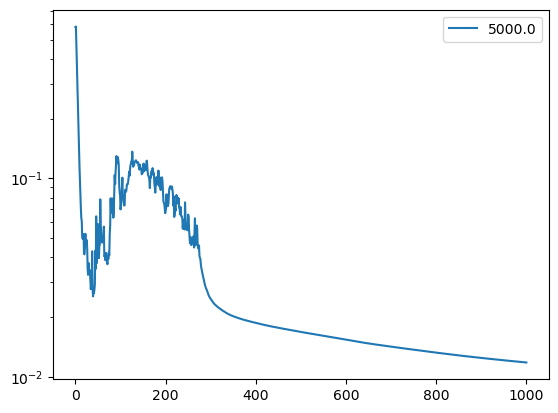

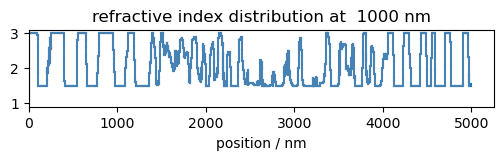

In [100]:
for rep in range(1):
    print(calculate_RMS_f_spec(
            best_film_rep[rep][-1], 
            make_reflection_design(wls=np.linspace(400, 1500, 500)).target_specs
        )) # well I think this is when the grad explodes... using smaller grad


fig, ax = plt.subplots(1, 1)
for gt, losses in zip(gts, losses_rep[-1]):
    ax.plot(losses, label=f'{gt}')
ax.legend()
ax.set_yscale('log')

plot_layer_thickness(best_film_rep[-1][-1])

8

save & load result

In [40]:
from analyze_utils.result_io import save, load
save('back_reflector_result', films_rep, losses_rep, best_film_rep)
# films_rep, losses_rep = load('tmp')


plot film structure

film has no spec. use 700 nm


c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


film has no spec. use 1000 nm
film has no spec. use 700 nm
film has no spec. use 1000 nm
film has no spec. use 700 nm
film has no spec. use 1000 nm


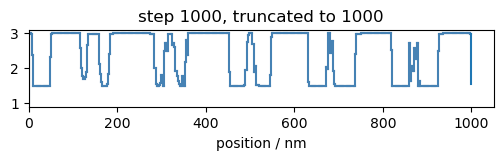

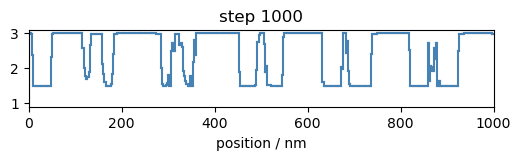

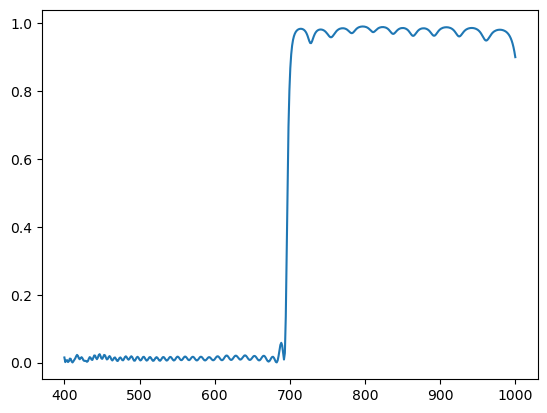

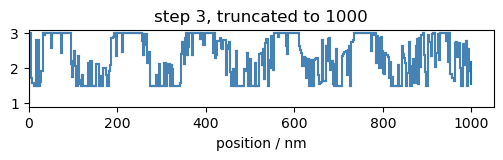

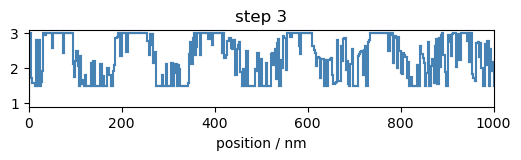

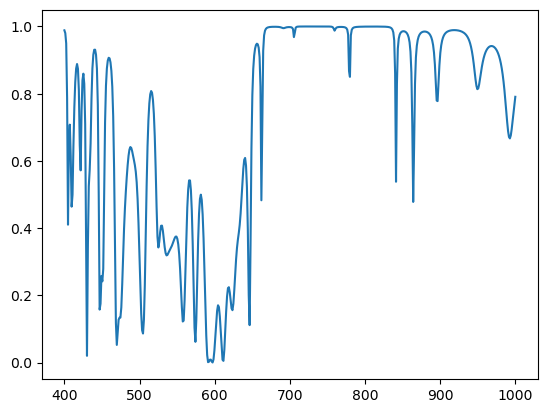

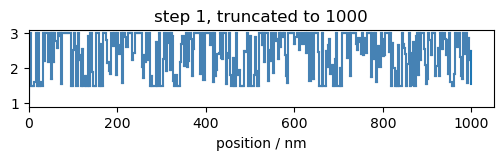

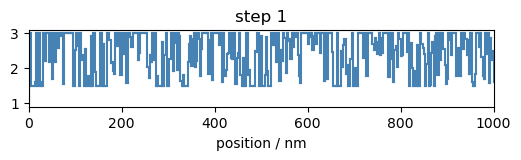

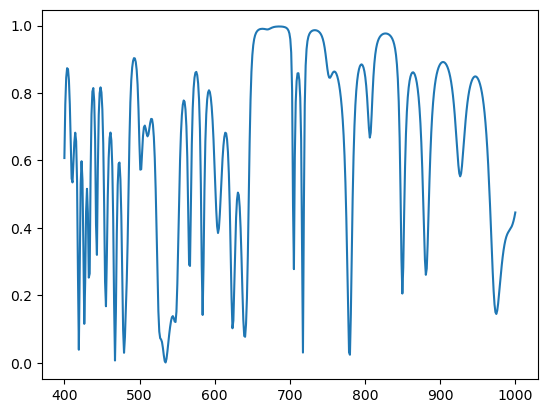

In [36]:
from analyze_utils.structure import plot_layer_thickness

plot_i = [1, 3, -1]
param_id = 10 # OT idx. 0: min; -1: max
rep_id = 0
truncate_thickness = 1000
for i in plot_i[::-1]:
    f: BaseFilm = copy.deepcopy(films_rep[rep_id][param_id][i])

    wl = 700
    ax, fig = plot_layer_thickness(f, n_at_wl=wl, truncate_thickness=truncate_thickness)
    ax.set_title(f'step {i if i >= 0 else len(films_rep[rep_id][param_id]) + i}, truncated to {truncate_thickness}')
    # fig.savefig(fpath + f'step_{i}.png', dpi=300, bbox_inches='tight')

    ax, fig = plot_layer_thickness(films_rep[rep_id][param_id][i])
    ax.set_title(f'step {i if i >= 0 else len(films_rep[rep_id][param_id]) + i}')
    # fig.savefig(fpath + f'all_depth_step_{i}.png', dpi=300, bbox_inches='tight')

    # 0-th iter, not yet have spectrum.
    fig, ax = plt.subplots(1, 1)
    ax.plot(films_rep[rep_id][param_id][i].get_all_spec_list()[0].WLS, films_rep[rep_id][param_id][i].get_all_spec_list()[0].get_R())